<a href="https://colab.research.google.com/github/PhD-Gabriel-Caballero/RESSBIO/blob/main/S2_L2A_data_fetching_water_reservoirs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://githubtocolab.com/gee-community/geemap/blob/master/examples/notebooks/140_ee_to_xarray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

**Converting Earth Engine images to an Xarray Dataset**

This notebook demonstrates how to convert Earth Engine images to an Xarray Dataset using [xee](https://github.com/google/Xee).

In [1]:
!pip install -U geemap
!pip install PyCRS
!pip install eemont

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PyCRS: filename=PyCRS-1.0.2-py3-none-any.whl size=32687 sha256=49821f05c3b7c36f0d8e43225db27003c9175b42f10ea5cb785851d6c610c1a0
  Stored in directory: /root/.cache/pip/wheels/47/1d/70/7a5bdf33347e7c75e95b06b1fa38f076a59a9506653cc24aff
Successfully built PyCRS
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eemont: filename=eemont-0.3.6-py3-none-any.whl size=135742 sha256=43e7d75de798ce3bcb1dc069e44eab96b4b519acfc678dbd41dc7133ae740190
  Stored in directory: /root/.cache/pip/wheels/c2/79/2c/4fed17c3d3b466bbf4fe5872eec11f189147043b01152a4f75
  Created wheel for ee_extra: filename=ee_extra-0.0.15-py3-none-any.whl size=236753 sha256=2ef7ea7

In [2]:
import ee
import geemap
import sys
import pycrs

import xarray
import glob
import matplotlib.pyplot as plt
import datetime

import eemont
import pandas as pd

In [4]:
#geemap.ee_initialize()

try:
    ee.Authenticate()
    ee.Initialize(project='ee-gabibessel')
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [5]:
#
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
Map = geemap.Map(toolbar_ctrl=True, layer_ctrl=True)
Map.default_style = {'cursor': 'crosshair'}
Map.add_basemap('SATELLITE')

# Center the map in the desired country
country = 'Spain'
country_bounds = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filterMetadata('country_na', 'equals', country);
Map.centerObject(country_bounds,8)
Map

Map(center=[40.35722509547827, -3.499564837147696], controls=(WidgetControl(options=['position', 'transparent_…

In [7]:
!rm -r RESSBIO # delete the complete repository folder
!git clone https://github.com/Grcf2585/RESSBIO # clone repository folder
sys.path.insert(0,'/content/RESSBIO')

rm: cannot remove 'RESSBIO': No such file or directory
Cloning into 'RESSBIO'...
remote: Enumerating objects: 409, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 409 (delta 90), reused 28 (delta 28), pack-reused 262 (from 1)
Receiving objects: 100% (409/409), 50.58 MiB | 12.74 MiB/s, done.
Resolving deltas: 100% (220/220), done.


In [8]:
roi_Bellus = geemap.shp_to_ee('/content/RESSBIO/Vectorial/Bellus.shp')
Map.addLayer(roi_Bellus, {},'Bellus ROI',True)

In [10]:
study_roi = Map.draw_last_feature

In [11]:
# Define your study region as a GeoJSON feature or feature collection
region = ee.FeatureCollection(study_roi)

In [ ]:
#
d1='2023-01-01'
d2= '2022-12-16'

# Define a dictionary containing sampling points and dates
sampling_points = {
    "point1": {"lat": -34.6037, "lon": -58.3772, "date": d1},
    "point2": {"lat": 41.8899, "lon": 12.4923, "date": d2},
}
sampling_points

{'point1': {'lat': -34.6037, 'lon': -58.3772, 'date': '2023-01-01'},
 'point2': {'lat': 41.8899, 'lon': 12.4923, 'date': '2022-12-16'}}

In [12]:
sampling_points_df = pd.read_csv('/content/drive/MyDrive/RESSBIO_Bellus_collections/BE_insitu_samples_2017_2024.csv')
#sampling_points_df = pd.read_csv('/content/drive/MyDrive/RESSBIO_Bellus_collections/BE_2027_2024_S2_L2A_sampling_points.csv')
#sampling_points_df = pd.read_csv('/content/drive/MyDrive/MyDrive/INTA/Puntos_S2_Trigo20_23_HA.csv')

# Convert the DataFrame to a Dictionary
sampling_points_dict = sampling_points_df.to_dict(orient='records')
sampling_points_dict

[{'Name': 'BL170615_P1',
  'date': '2017-06-15',
  'TIME (UTC)': nan,
  'lat': 38.93481275,
  'lon': -0.474777402,
  'Z_SECCHI': 0.55,
  'SAMPLING depth': nan,
  'CONDUCTIVITY': nan,
  'TEMP': 28.5,
  'a440(CDOM)': 1.5,
  'CHLOROPHYLL a (Abs)': 61.4,
  'Chl_a Flor in situ': nan,
  'PC (FLUOR)': 185.43,
  'TSS': 19.76,
  'POM': 17.23,
  'PIM': 2.53},
 {'Name': 'BL170615_P2',
  'date': '2017-06-15',
  'TIME (UTC)': nan,
  'lat': 38.93114005,
  'lon': -0.469936182,
  'Z_SECCHI': 0.5,
  'SAMPLING depth': nan,
  'CONDUCTIVITY': nan,
  'TEMP': nan,
  'a440(CDOM)': 1.35,
  'CHLOROPHYLL a (Abs)': 66.77,
  'Chl_a Flor in situ': nan,
  'PC (FLUOR)': nan,
  'TSS': 21.41,
  'POM': 17.79,
  'PIM': 3.62},
 {'Name': 'BL170615_P3',
  'date': '2017-06-15',
  'TIME (UTC)': nan,
  'lat': 38.9281435,
  'lon': -0.475094766,
  'Z_SECCHI': 0.55,
  'SAMPLING depth': nan,
  'CONDUCTIVITY': nan,
  'TEMP': nan,
  'a440(CDOM)': 1.39,
  'CHLOROPHYLL a (Abs)': 68.01,
  'Chl_a Flor in situ': nan,
  'PC (FLUOR)': nan

In [13]:
# Define a function to filter the SR and s2cloudless collections according to area of interest and date parameters,
# then join them on the system:index property. The result is a copy of the SR collection where each image has a new
# 's2cloudless' property whose value is the corresponding s2cloudless image.

# Function to extract reflectance at a point and date
def get_reflectance_cloudless(point, date,delta_time,cloud_threshod):

  ################################################################
  # Convert sampling point to a geometry point
  point_geometry = ee.Geometry.Point([point["lon"], point["lat"]])

  ################################################################
  # Define date as a filter for Sentinel-2 L2A images
  # Define a date range for filtering (delta_time days before and after)

  max_date =  datetime.datetime.strptime(date, "%Y-%m-%d") + datetime.timedelta(days=delta_time)
  min_date =  datetime.datetime.strptime(date, "%Y-%m-%d") + datetime.timedelta(days=-delta_time)
  dateRange = ee.DateRange(min_date, max_date)
  date_filter = ee.Filter.date(dateRange)

  ###################################################################
  # Filter the Sentinel-2 L2A image collection within the date range

  # Import and filter S2 SR.
  s2_sr_col = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
      .filterBounds(point_geometry)\
      .filter(date_filter) \
      .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE',cloud_threshod))

  # Import and filter s2cloudless.
  s2_cloudless_col = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')\
      .filterBounds(point_geometry)\
      .filter(date_filter) \

  # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
  return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
      'primary': s2_sr_col,
      'secondary': s2_cloudless_col,
      'condition': ee.Filter.equals(**{'leftField': 'system:index','rightField': 'system:index'})})),s2_sr_col,s2_cloudless_col

# Function to extract the desired band as a property
def extractBandAsProperty(image,roi):

  cloud_probability = image.select('cloud_probability').reduceRegion(
      reducer=ee.Reducer.mean(),
      geometry=roi,
      scale=10  # Adjust scale as needed
  ).get('cloud_probability')

  return image.set('S2CP', cloud_probability)

# Function to add the cloud probabilty band
def add_s2cloudless_band(image):

  # Get s2cloudless probability
  band2add = ee.Image(image.get('s2cloudless')).select('probability').rename('cloud_probability')

  # Add NDVI band to the image
  return image.addBands(band2add)

In [15]:
# Function to extract reflectance at a point and date

def get_reflectance_data(s2_collection,point,date):

  ################################################################
  # Convert sampling point to a geometry point
  point_geometry = ee.Geometry.Point([point["lon"], point["lat"]])
  ################################################################

  #s2_collection.closest(date)

  ###################################
  # Check if any images are available
  if s2_collection.size().getInfo() > 0:
    # Sort the images by cloud cover
    sorted_collection = s2_collection.sort('cloud_probability', False)
    # Get the first image (assuming one image per overpass)
    sentinel2_image = sorted_collection.first()

    ##########################################
    # Extract reflectance values for all bands
    # Select bands B11 and B12
    b11_b12 = sentinel2_image.select(['B11', 'B12'])

    # Calculate the mean value of the two bands
    mean_swir_value = b11_b12.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    scale=60  # Adjust the scale as needed
                    )

    #sentinel2_image_deglint = sentinel2_image.subtract(sentinel2_image.select(['B12'])).max(0)
    sentinel2_image_deglint = sentinel2_image

    reflectance = sentinel2_image_deglint.select('B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12').divide(10000).reduceRegion(
        reducer=ee.Reducer.mean(), geometry=point_geometry)
    metadata = sentinel2_image.select('QA60','SCL','cloud_probability').reduceRegion(
        reducer=ee.Reducer.mean(), geometry=point_geometry)
    ####################################################################
    # Calculate difference in days between acquisition and sampling date
    acquisition_date = sentinel2_image.get('system:time_start')
    date_diff = ee.Date(date).difference(ee.Date(acquisition_date), 'days')

    ###################################
    # Create a dictionary with results
    return {
        "Name":point["Name"],
        "lon": point["lon"],
        "lat": point["lat"],
        "Sampling_date": date,
        "SDD": point['Z_SECCHI'],
        "Sampling depth": point['SAMPLING depth'],
        "Conductivity":point['CONDUCTIVITY'],
        "Water temp": point['TEMP'],
        "CDOM": point['a440(CDOM)'],
        "Chl-a": point['CHLOROPHYLL a (Abs)'],
        "Chl_a Flor": point['Chl_a Flor in situ'],
        "PC (FLUOR)": point['PC (FLUOR)'],
        "TSS": point['TSS'],
        "POM": point['POM'],
        "PIM": point['PIM'],
        "S2_date":datetime.datetime.fromtimestamp(sentinel2_image.get('system:time_start').getInfo()/ 1000).strftime("%Y-%m-%d"), #sentinel2_image.get('system:index').getInfo()[0:8],
        "days_diff": round(ee.Number(date_diff).abs().getInfo(),0),
        "S2_product_ID":sentinel2_image.get('PRODUCT_ID').getInfo(),
        **reflectance.getInfo(),  # Extract all reflectance band values
        **metadata.getInfo(), # Extract all metadata
        "CPP": sentinel2_image.get('CLOUDY_PIXEL_PERCENTAGE').getInfo()
    }
  else:
    # No image found, return an empty dictionary
    return {
        "lon": point["lon"],
        "lat": point["lat"],
        "Sampling_date": date,
    }

In [45]:
point_data = sampling_points_dict[5]

print(point_data)
region = ee.Geometry.Point([point_data["lon"], point_data["lat"]])

result = get_reflectance_cloudless(point_data, point_data['date'],10,90)

retrieved_s2_collection = result[0]
# Apply the function to the image collection
retrieved_s2cloudless_collection = ee.ImageCollection(retrieved_s2_collection.map(add_s2cloudless_band))

# Apply the function to the image collection
S2CP_image_collection = retrieved_s2cloudless_collection.map(lambda image: extractBandAsProperty(image, region))
S2CP_image_collection_sorted = S2CP_image_collection.sort('S2CP')

S2CP_image_collection_sorted

S2_data = get_reflectance_data(S2CP_image_collection_sorted,point_data,point_data['date'])
S2_data

{'Name': 'BL180322_P3', 'date': '2018-03-22', 'TIME (UTC)': nan, 'lat': 38.92898885, 'lon': -0.472942423, 'Z_SECCHI': 0.45, 'SAMPLING depth': nan, 'CONDUCTIVITY': nan, 'TEMP': 14.0, 'a440(CDOM)': 1.08, 'CHLOROPHYLL a (Abs)': 49.09, 'Chl_a Flor in situ': nan, 'PC (FLUOR)': 307.93, 'TSS': 21.83, 'POM': 14.57, 'PIM': 7.26}


{'Name': 'BL180322_P3',
 'lon': -0.472942423,
 'lat': 38.92898885,
 'Sampling_date': '2018-03-22',
 'SDD': 0.45,
 'Sampling depth': nan,
 'Conductivity': nan,
 'Water temp': 14.0,
 'CDOM': 1.08,
 'Chl-a': 49.09,
 'Chl_a Flor': nan,
 'PC (FLUOR)': 307.93,
 'TSS': 21.83,
 'POM': 14.57,
 'PIM': 7.26,
 'S2_date': '2018-03-22',
 'days_diff': 0.0,
 'S2_product_ID': 'S2A_MSIL2A_20180322T105021_N0206_R051_T30SYJ_20180322T111317',
 'B1': 0.0207,
 'B11': 0,
 'B12': 0,
 'B2': 0.0269,
 'B3': 0.0571,
 'B4': 0.0287,
 'B5': 0.0718,
 'B6': 0.0207,
 'B7': 0.0179,
 'B8': 0.0127,
 'B8A': 0.0035,
 'B9': 0,
 'QA60': 0,
 'SCL': 6,
 'cloud_probability': 0,
 'CPP': 0.1312}

In [16]:
# Loop through sampling points and dates, call the function
delta = 6
S2PP = 90

S2_L2A_reflectance = []
for point_data in sampling_points_dict:
  result = get_reflectance_cloudless(point_data, point_data['date'],delta,S2PP)
  retrieved_s2_collection = result[0]

  # Apply the function to the image collection
  retrieved_s2cloudless_collection = ee.ImageCollection(retrieved_s2_collection.map(add_s2cloudless_band))
  # Apply the function to the image collection
  S2CP_image_collection = retrieved_s2cloudless_collection.map(lambda image: extractBandAsProperty(image, region))
  S2CP_image_collection_sorted = S2CP_image_collection.sort('S2CP')

  S2_data = get_reflectance_data(S2CP_image_collection_sorted,point_data,point_data['date'])

  if S2_data :
    S2_L2A_reflectance.append(S2_data)

In [17]:
S2_L2A_reflectance_df = pd.DataFrame.from_dict(S2_L2A_reflectance,orient='columns')
S2_L2A_reflectance_df

,Name,lon,lat,Sampling_date,SDD,Sampling depth,Conductivity,Water temp,CDOM,Chl-a,...,B5,B6,B7,B8,B8A,B9,QA60,SCL,cloud_probability,CPP
0,BL170615_P1,-0.474777,38.934813,2017-06-15,0.55,NaN,NaN,28.50,1.50,61.40,...,0.1201,0.0619,0.0587,0.0608,0.0471,0.0367,0,7,3,0.000000
1,BL170615_P2,-0.469936,38.931140,2017-06-15,0.50,NaN,NaN,NaN,1.35,66.77,...,0.1020,0.0452,0.0454,0.0445,0.0364,0.0239,0,2,2,0.000000
2,BL170615_P3,-0.475095,38.928143,2017-06-15,0.55,NaN,NaN,NaN,1.39,68.01,...,0.0996,0.0474,0.0452,0.0416,0.0361,0.0191,0,2,2,0.000000
3,BL180322_P1,-0.477221,38.934226,2018-03-22,0.50,NaN,NaN,13.60,1.54,41.54,...,0.0801,0.0252,0.0233,0.0171,0.0083,0.0001,0,6,0,0.365828
4,BL180322_P2,-0.476744,38.932702,2018-03-22,0.45,NaN,NaN,13.50,1.13,51.59,...,0.0769,0.0260,0.0238,0.0187,0.0085,0.0001,0,6,0,0.365828
5,BL180322_P3,-0.472942,38.928989,2018-03-22,0.45,NaN,NaN,14.00,1.08,49.09,...,0.0813,0.0240,0.0221,0.0163,0.0071,0.0001,0,6,0,0.365828
6,BL200625001,-0.473796,38.930935,2020-06-25,0.65,9.60,NaN,28.48,NaN,NaN,...,0.0488,0.0088,0.0092,0.0061,0.0026,0.0002,0,6,1,8.226708
7,BL200625002,-0.471977,38.931175,2020-06-25,0.65,8.10,NaN,28.57,NaN,NaN,...,0.0462,0.0079,0.0079,0.0055,0.0015,0.0001,0,6,1,8.226708
8,BL200625003,-0.472548,38.930025,2020-06-25,0.66,8.50,NaN,28.69,1.01,31.75,...,0.0482,0.0096,0.0090,0.0064,0.0023,0.0002,0,6,0,8.226708
9,BL200625004,-0.473381,38.928647,2020-06-25,0.70,7.50,NaN,29.37,NaN,NaN,...,0.0494,0.0105,0.0106,0.0078,0.0030,NaN,0,6,0,8.226708


In [ ]:
S2_L2A_reflectance_df

In [19]:
# Save the DataFrame to a CSV file
S2_L2A_reflectance_df.to_csv('/content/drive/MyDrive/RESSBIO_Bellus_collections/BE_2017_2024_S2_L2A_BOA_data.csv', index=False)

<Axes: >

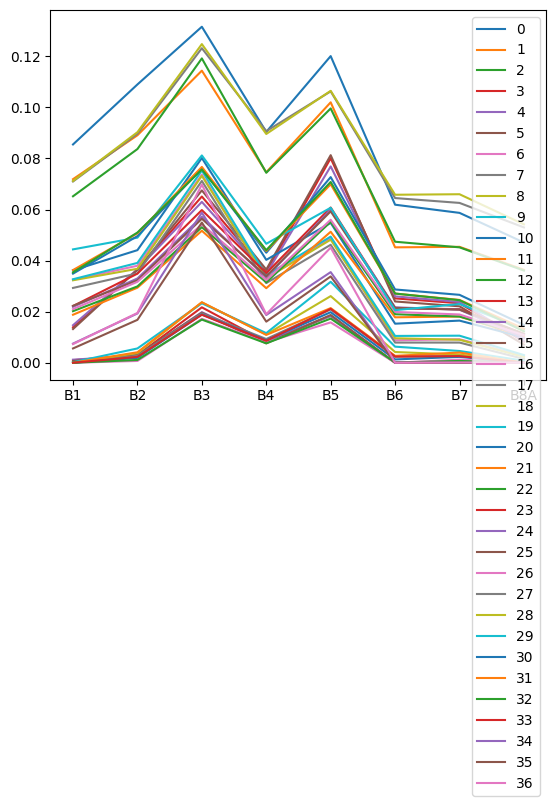

In [18]:
S2_L2A_reflectance_df_bands = S2_L2A_reflectance_df.loc[:,['B1','B2','B3','B4','B5','B6','B7','B8A']]
S2_L2A_reflectance_df_bands.transpose().plot()

In [ ]:
for i in range(0,result[2].size().getInfo()):
    value = ee.Image(imageList[i]).select('probability').reduceRegion(reducer=ee.Reducer.mean(), geometry=region)['probability'].getInfo()
    print(value)

None
None
100
None
100
None
None
100
None
100
None
None
100
None
100
None
None
13
None
99
None
13
None
15


In [ ]:
RGB_image_list
result[0]

# Sort the image collection by the 'cloud_cover' property
sortedCollection = result[0].sort('probability')  # Ascending order
sortedCollection

RGB_image_list = sortedCollection.toList(sortedCollection[0].size().getInfo())
sortedCollection
#ee.Image(RGB_image_list[0].get('s2cloudless')) #.select('probability').getInfo()

# Get s2cloudless image, subset the probability band.
cld_prb = ee.Image(ee.Image(RGB_image_list[2]).get('s2cloudless')).select('probability').reduceRegion(reducer=ee.Reducer.mean(), geometry=region)['probability'].getInfo()
cld_prb

13

In [ ]:
RGB_image_list = S2CP_image_collection_sorted.toList(S2CP_image_collection_sorted.size().getInfo())

In [ ]:
Map = geemap.Map()
# Create a composite image (e.g., mosaic)
mosaic = ee.Image(RGB_image_list[3])
# Add the mosaic to the map
Map.addLayer(mosaic, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Mosaic')

# Display the map
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# The code has been copied to the clipboard.
# Press Ctrl+V to in a code cell to paste it.
s2Sr = ee.ImageCollection('COPERNICUS/S2_SR')
s2Clouds = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')

START_DATE = ee.Date('2020-10-05')
END_DATE = ee.Date('2020-10-25')
MAX_CLOUD_PROBABILITY = 65
region = ee.Geometry.Point([point_data["lon"], point_data["lat"]])

def maskClouds(img):
    clouds = ee.Image(img.get('cloud_mask')).select('probability')
    isNotCloud = clouds.lt(MAX_CLOUD_PROBABILITY)
    return img.updateMask(isNotCloud)

# The masks for the 10m bands sometimes do not exclude bad data at
# scene edges, so we apply masks from the 20m and 60m bands as well.
# Example asset that needs this operation:
# COPERNICUS/S2_CLOUD_PROBABILITY/20190301T000239_20190301T000238_T55GDP

def maskEdges(s2_img):
    return s2_img.updateMask(
    s2_img.select('B8A').mask().updateMask(s2_img.select('B9').mask()))

# Filter input collections by desired data range and region.
criteria = ee.Filter.And(
ee.Filter.bounds(region), ee.Filter.date(START_DATE, END_DATE))
s2Sr = s2Sr.filter(criteria).map(maskEdges)
s2Clouds = s2Clouds.filter(criteria)

# Join S2 SR with cloud probability dataset to add cloud mask.
s2SrWithCloudMask = ee.Join.saveFirst('cloud_mask').apply(
primary = s2Sr,
secondary = s2Clouds,
condition =
ee.Filter.equals(**{'leftField':'system =index', 'rightField':'system =index'})
)

s2CloudMasked = \
ee.ImageCollection(s2SrWithCloudMask).map(maskClouds).mean()
rgbVis = {'min': 0, 'max': 3000, 'bands': ['B4', 'B3', 'B2']}

Map.addLayer(s2CloudMasked, rgbVis, 'S2 SR masked at ') # + MAX_CLOUD_PROBABILITY + '%','True')
Map

Map(bottom=40874.0, center=[-39.359785268690004, -60.78147679129872], controls=(WidgetControl(options=['positi…

In [ ]:
# Define a function to add the s2cloudless probability layer and derived cloud mask as bands to an S2 SR image input.

def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

In [ ]:
# Function to extract reflectance at a point and date
def get_reflectance(point, date,delta_time):

  ################################################################
  # Convert sampling point to a geometry point
  point_geometry = ee.Geometry.Point([point["lon"], point["lat"]])

  ################################################################
  # Define date as a filter for Sentinel-2 L2A images
  # Define a date range for filtering (delta_time days before and after)

  max_date =  datetime.datetime.strptime(date, "%Y-%m-%d") + datetime.timedelta(days=delta_time)
  min_date =  datetime.datetime.strptime(date, "%Y-%m-%d") + datetime.timedelta(days=-delta_time)
  dateRange = ee.DateRange(min_date, max_date)
  date_filter = ee.Filter.date(dateRange)

  ###################################################################
  # Filter the Sentinel-2 L2A image collection within the date range
  s2_collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
      .filter(date_filter) \
      .filterBounds(point_geometry)\
      .closest(date)

  ###################################
  # Check if any images are available
  if s2_collection.size().getInfo() > 0:
    # Get the first image (assuming one image per overpass)
    sentinel2_image = s2_collection.first()

    ##########################################
    # Extract reflectance values for all bands
    reflectance = sentinel2_image.select('B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12').divide(10000).reduceRegion(
        reducer=ee.Reducer.mean(), geometry=point_geometry)
    metadata = sentinel2_image.select('QA60','SCL').reduceRegion(
        reducer=ee.Reducer.mean(), geometry=point_geometry)
    ####################################################################
    # Calculate difference in days between acquisition and sampling date
    acquisition_date = sentinel2_image.get('system:time_start')
    date_diff = ee.Date(date).difference(ee.Date(acquisition_date), 'days')

    ###################################
    # Create a dictionary with results
    return {
        "lon": point["lon"],
        "lat": point["lat"],
        "Sampling_date": date,
        "S2_date": sentinel2_image.get('system:index').getInfo()[0:8],
        "days_diff": round(ee.Number(date_diff).abs().getInfo(),0),
        "S2_product_ID":sentinel2_image.get('PRODUCT_ID').getInfo(),
        **reflectance.getInfo(),  # Extract all reflectance band values
        **metadata.getInfo(), # Extract all metadata
        "CPP": sentinel2_image.get('CLOUDY_PIXEL_PERCENTAGE').getInfo()
    }
  else:
    # No image found, return an empty dictionary
    return {
        "lon": point["lon"],
        "lat": point["lat"],
        "Sampling_date": date,
    }

In [ ]:
def get_closest_cloud_free_s2_image(geometry, target_date,delta_time):
  """
  Finds the Sentinel-2 image closest to the target date with minimal cloud cover.

  Args:
    geometry: The geometry of the area of interest.
    target_date: The target date as an ee.Date object.

  Returns:
    The closest cloud-free Sentinel-2 image.
  """

  # Load Sentinel-2 SR image collection
  s2_sr = ee.ImageCollection('COPERNICUS/S2_SR')

  # Filter by date range (adjust the +/- days as needed)
  #max_date =  datetime.datetime.strptime(target_date, "%Y-%m-%d") + datetime.timedelta(days=delta_time)
  #min_date =  datetime.datetime.strptime(target_date, "%Y-%m-%d") + datetime.timedelta(days=-delta_time)
  #date_range = ee.DateRange(min_date, max_date)
  #date_filter = ee.Filter.date(dateRange)

  date_range = target_date.advance(-7, 'day'), target_date.advance(7, 'day')
  s2_filtered = s2_sr.filterDate(*date_range).filterBounds(geometry)

  def add_cloud_cover_band(image):
    # Get the SCL band
    scl = image.select('SCL')

    # Define cloud mask based on SCL values (adjust as needed)
    cloud_mask = scl.eq(4).Or(scl.eq(5))

    # Calculate cloud cover as a fraction
    cloud_cover = cloud_mask.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=image.geometry(),
        scale=10
    ).get('SCL')

    # Add the cloud cover band to the image
    return image.addBands(ee.Image(cloud_cover).rename('cloud_cover'))

  s2_with_cloud_cover = s2_filtered.map(add_cloud_cover_band)

  # Sort by distance to target date and cloud cover
  def distance_and_cloud_cover(image):
    distance = image.date().difference(target_date, 'day').abs()
    return image.set('distance', distance).set('cloud_cover', image.get('cloud_cover'))

  sorted_images = s2_with_cloud_cover.map(distance_and_cloud_cover).sort('distance', True).sort('cloud_cover', True)

  # Select the first image (closest with least cloud cover)
  closest_image = sorted_images.first()

  return closest_image

In [ ]:

# Sort by distance to target date and cloud cover
def distance_and_cloud_cover(image):
    distance = image.date().difference(target_date, 'day').abs()
    return image.set('distance', distance)

In [ ]:
# Example usage
delta_time = 7
geometry = ee.Geometry.Rectangle(-118.25, 34, -118, 34.2)  # Replace with your geometry
target_date = ee.Date('2023-07-15')

closest_image = get_closest_cloud_free_s2_image(geometry, target_date, delta_time)
print(closest_image.getInfo())

EEException: Collection.first: Error in map(ID=20230717T182919_20230717T183240_T11SMT):
Image.rename, argument 'input': Invalid type.
Expected type: Image<unknown bands>.
Actual type: Float.
Actual value: 0.7293047757348778

In [ ]:
for point_data in sampling_points_dict:
  print(point_data)

{'Name': 11, 'date': '2020-08-10', 'lon': -62.637008, 'lat': -39.399322}
{'Name': 12, 'date': '2020-08-10', 'lon': -62.637349, 'lat': -39.399061}
{'Name': 13, 'date': '2020-08-10', 'lon': -62.637715, 'lat': -39.398789}
{'Name': 21, 'date': '2020-08-10', 'lon': -62.638508, 'lat': -39.400421}
{'Name': 22, 'date': '2020-08-10', 'lon': -62.63874, 'lat': -39.400154}
{'Name': 23, 'date': '2020-08-10', 'lon': -62.638977, 'lat': -39.399963}
{'Name': 31, 'date': '2020-08-10', 'lon': -62.6407, 'lat': -39.402055}
{'Name': 32, 'date': '2020-08-10', 'lon': -62.641052, 'lat': -39.401879}
{'Name': 33, 'date': '2020-08-10', 'lon': -62.641396, 'lat': -39.401598}
{'Name': 11, 'date': '2020-09-03', 'lon': -62.637008, 'lat': -39.399322}
{'Name': 12, 'date': '2020-09-03', 'lon': -62.637349, 'lat': -39.399061}
{'Name': 13, 'date': '2020-09-03', 'lon': -62.637715, 'lat': -39.398789}
{'Name': 21, 'date': '2020-09-03', 'lon': -62.638508, 'lat': -39.400421}
{'Name': 22, 'date': '2020-09-03', 'lon': -62.63874, '

In [ ]:
# Loop through sampling points and dates, call the function
delta = 7
S2_L2A_reflectance = []
for point_data in sampling_points_dict:
  result = get_reflectance(point_data, point_data['date'],delta)
  if result:
    S2_L2A_reflectance.append(result)

In [ ]:
point_data = sampling_points_dict[0]

result = get_reflectance(point_data, point_data['date'],10)
result

{'lon': -62.637008,
 'lat': -39.399322,
 'Sampling_date': '2020-08-10',
 'S2_date': '20200809',
 'days_diff': 0.0,
 'S2_product_ID': 'S2A_MSIL2A_20200809T140101_N0214_R067_T20HNB_20200809T180016',
 'B11': 0.4207,
 'B12': 0.4238,
 'B2': 0.5088,
 'B3': 0.486,
 'B4': 0.4704,
 'B5': 0.5081,
 'B6': 0.5194,
 'B7': 0.5115,
 'B8': 0.5352,
 'B8A': 0.5037,
 'QA60': 1024,
 'SCL': 9,
 'CPP': 99.846747}

In [ ]:
S2_L2A_reflectance_df = pd.DataFrame.from_dict(S2_L2A_reflectance,orient='columns')
S2_L2A_reflectance_df

NameError: name 'pd' is not defined

In [ ]:
# Loop through sampling points and dates, call the function
delta = 20
S2_L2A_reflectance = []
for point_name, point_data in sampling_points.items():
  result = get_reflectance(point_data, point_data["date"],delta)
  if result:
    S2_L2A_reflectance.append(result)

# Print the results (consider exporting to a CSV file for better handling)
print(S2_L2A_reflectance)

[{'lon': -58.3772, 'lat': -34.6037, 'Sampling_date': '2023-01-01', 'S2_date': '20221229', 'days_diff': 2.0, 'S2_product_ID': 'S2B_MSIL2A_20221229T134709_N0509_R024_T21HUB_20221229T174647', 'B1': 0.099, 'B2': 0.1345, 'B3': 0.1503, 'B4': 0.1589, 'B5': 0.1708, 'B6': 0.1732, 'B7': 0.1734, 'B8': 0.1598, 'B9': 0.1489}, {'lon': 12.4923, 'lat': 41.8899, 'Sampling_date': '2022-12-16', 'S2_date': '20221216', 'days_diff': 0.0, 'S2_product_ID': 'S2B_MSIL2A_20221216T100329_N0509_R122_T32TQM_20221216T112735', 'B1': 1.1519, 'B2': 1.1134, 'B3': 1.0723, 'B4': 1.0609, 'B5': 1.1034, 'B6': 1.0791, 'B7': 1.0674, 'B8': 1.1095, 'B9': 1.5004}]


In [ ]:
S2_L2A_reflectance_df = pd.DataFrame.from_dict(S2_L2A_reflectance,orient='columns')
S2_L2A_reflectance_df

,lon,lat,Sampling_date,S2_date,days_diff,S2_product_ID,B1,B2,B3,B4,B5,B6,B7,B8,B9
0,-58.3772,-34.6037,2023-01-01,20221229,2.0,S2B_MSIL2A_20221229T134709_N0509_R024_T21HUB_2...,0.0990,0.1345,0.1503,0.1589,0.1708,0.1732,0.1734,0.1598,0.1489
1,12.4923,41.8899,2022-12-16,20221216,0.0,S2B_MSIL2A_20221216T100329_N0509_R122_T32TQM_2...,1.1519,1.1134,1.0723,1.0609,1.1034,1.0791,1.0674,1.1095,1.5004


In [ ]:
s2_collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
      .filterBounds(point_geometry)

sentinel2_image = s2_collection.first()
sentinel2_image.getInfo()
s2_collection

MOD16A2 = ee.ImageCollection('MODIS/006/MOD16A2').select('ET')
MOD16A2 = MOD16A2.closest('2020-10-16')
MOD16A2

In [ ]:
sentinel2_image = s2_collection.first()
sentinel2_image.getInfo()

{'type': 'Image',
 'bands': [{'id': 'B1',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [1830, 1830],
   'crs': 'EPSG:32721',
   'crs_transform': [60, 0, 300000, 0, -60, 6200020]},
  {'id': 'B2',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32721',
   'crs_transform': [10, 0, 300000, 0, -10, 6200020]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32721',
   'crs_transform': [10, 0, 300000, 0, -10, 6200020]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32721',
   'crs_transform': [10, 0, 300000, 0, -10, 6200020]},
  {'id': 'B5',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min':

In [ ]:
start_date = '2023-01-01'
end_date = '2023-12-31'
CLOUD_FILTER = 30

In [ ]:
i = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterBounds(roi_Bellus).filterDate(start_date, end_date).filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))
ds = xarray.open_dataset(i, engine='ee')

In [ ]:
geometry = ee.Geometry.Rectangle(-0.4366457028875175, 38.90208924666092,-0.4979814168160033, 38.94254011834727)

#geometry = ee.Geometry.Rectangle(-1,30,1,40)

In [ ]:
ds = geemap.ee_to_xarray(i, crs="EPSG:25830", scale=10, geometry=geometry)
ds

<xarray.Dataset>
Dimensions:     (time: 87, X: 519, Y: 464)
Coordinates:
  * time        (time) datetime64[ns] 2023-01-05T11:00:13.939000 ... 2023-12-...
  * X           (X) float64 7.17e+05 7.17e+05 7.17e+05 ... 7.221e+05 7.222e+05
  * Y           (Y) float64 4.309e+06 4.309e+06 ... 4.314e+06 4.314e+06
Data variables: (12/23)
    B1          (time, X, Y) float32 ...
    B2          (time, X, Y) float32 ...
    B3          (time, X, Y) float32 ...
    B4          (time, X, Y) float32 ...
    B5          (time, X, Y) float32 ...
    B6          (time, X, Y) float32 ...
    ...          ...
    TCI_B       (time, X, Y) float32 ...
    MSK_CLDPRB  (time, X, Y) float32 ...
    MSK_SNWPRB  (time, X, Y) float32 ...
    QA10        (time, X, Y) float32 ...
    QA20        (time, X, Y) float32 ...
    QA60        (time, X, Y) float32 ...
Attributes: (12/18)
    date_range:             [1490659200000, 1647907200000]
    description:            <p>Sentinel-2 is a wide-swath, high-resolution, m...
    keywords:               ['copernicus', 'esa', 'eu', 'msi', 'reflectance',...
    period:                 0
    product_tags:           ['msi', 'sr', 'reflectance']
    provider:               European Union/ESA/Copernicus
    ...                     ...
    type_name:              ImageCollection
    visualization_0_bands:  B4,B3,B2
    visualization_0_max:    3000.0
    visualization_0_min:    0.0
    visualization_0_name:   RGB
    crs:                    EPSG:25830

<xarray.DataArray 'B4' (time: 87, X: 519, Y: 464)>
[20950992 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2023-01-05T11:00:13.939000 ... 2023-12-26T...
  * X        (X) float64 7.17e+05 7.17e+05 7.17e+05 ... 7.221e+05 7.222e+05
  * Y        (Y) float64 4.309e+06 4.309e+06 4.309e+06 ... 4.314e+06 4.314e+06
Attributes:
    id:             B4
    data_type:      {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max'...
    dimensions:     [10980, 10980]
    crs:            EPSG:25830
    crs_transform:  [10, 0, 699960, 0, -10, 4400040]

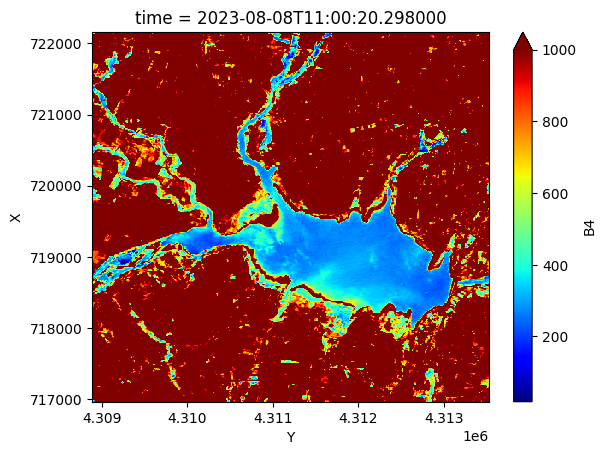

In [ ]:
ds.B4[49,:,:].plot(cmap='jet', vmax=1000)
#plt.ylim(-0.4366457028875175,-0.4979814168160033)
#plt.xlim(38.90208924666092,38.94254011834727)
#plt.ylim(-2,2)
#plt.xlim(35,45)
ds.B4

In [ ]:
ds.to_netcdf('/content/drive/saved_on_disk.nc')

EEException: Total request size (57016320 bytes) must be less than or equal to 50331648 bytes.

In [ ]:
geemap.ee_export_image_to_drive(
     i.toBands(), description='S2_Bellus_collection', folder='RESSBIO_Bellus_collections', region=roi_Bellus.geometry(), scale=10
)

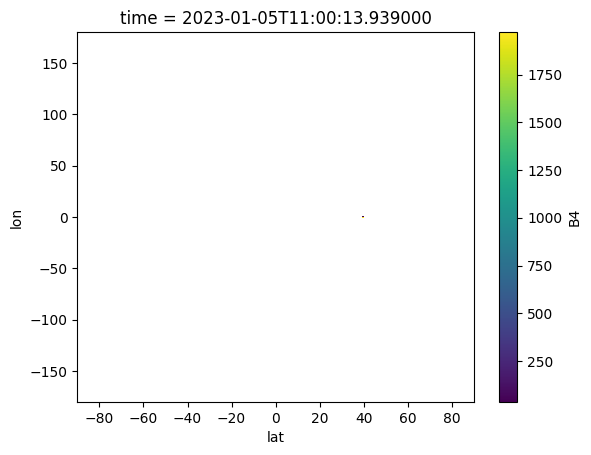

In [ ]:
ds = geemap.ee_to_xarray(ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(roi_Bellus)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))
ds.B4[0,:,:].plot()

In [ ]:
geemap.xee_to_image(ds, filenames=["Bellus_s2_collection.tif"])

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 1.4 MB/s eta 0:00:00
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 28.8 MB/s eta 0:00:00


ValueError: The number of filenames must match the number of time steps

Opening the [ERA5-Land hourly dataset](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY) in Earth Engine and converting it to an Xarray Dataset. This is a huge dataset and it may take a minute or two to load. Please be patient.

In [ ]:
ds = geemap.ee_to_xarray("ECMWF/ERA5_LAND/HOURLY", n_images=100)
ds

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.7 MB/s eta 0:00:00


<xarray.Dataset>
Dimensions:                                                       (time: 100,
                                                                   lon: 360,
                                                                   lat: 180)
Coordinates:
  * time                                                          (time) datetime64[ns] ...
  * lon                                                           (lon) float64 ...
  * lat                                                           (lat) float64 ...
Data variables: (12/69)
    dewpoint_temperature_2m                                       (time, lon, lat) float32 ...
    temperature_2m                                                (time, lon, lat) float32 ...
    skin_temperature                                              (time, lon, lat) float32 ...
    soil_temperature_level_1                                      (time, lon, lat) float32 ...
    soil_temperature_level_2                                      (time, lon, lat) float32 ...
    soil_temperature_level_3                                      (time, lon, lat) float32 ...
    ...                                                            ...
    runoff_hourly                                                 (time, lon, lat) float32 ...
    snow_evaporation_hourly                                       (time, lon, lat) float32 ...
    sub_surface_runoff_hourly                                     (time, lon, lat) float32 ...
    surface_runoff_hourly                                         (time, lon, lat) float32 ...
    total_evaporation_hourly                                      (time, lon, lat) float32 ...
    total_precipitation_hourly                                    (time, lon, lat) float32 ...
Attributes: (12/33)
    date_range:               [347155200000, 1640649600000]
    description:              <p>ERA5-Land is a reanalysis dataset providing ...
    keywords:                 ['cds', 'climate', 'copernicus', 'ecmwf', 'era5...
    period:                   0
    product_tags:             ['temperature', 'lakes', 'snow', 'soil_water', ...
    provider:                 Climate Data Store
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

Open all bands in a specific projection and spatial resolution. Similarly, it may take a minute or two to load.

In [ ]:
ds = geemap.ee_to_xarray(
    "ECMWF/ERA5_LAND/HOURLY", crs="EPSG:4326", scale=0.25, n_images=100
)
ds

<xarray.Dataset>
Dimensions:                                                       (time: 100,
                                                                   lon: 1440,
                                                                   lat: 720)
Coordinates:
  * time                                                          (time) datetime64[ns] ...
  * lon                                                           (lon) float64 ...
  * lat                                                           (lat) float64 ...
Data variables: (12/69)
    dewpoint_temperature_2m                                       (time, lon, lat) float32 ...
    temperature_2m                                                (time, lon, lat) float32 ...
    skin_temperature                                              (time, lon, lat) float32 ...
    soil_temperature_level_1                                      (time, lon, lat) float32 ...
    soil_temperature_level_2                                      (time, lon, lat) float32 ...
    soil_temperature_level_3                                      (time, lon, lat) float32 ...
    ...                                                            ...
    runoff_hourly                                                 (time, lon, lat) float32 ...
    snow_evaporation_hourly                                       (time, lon, lat) float32 ...
    sub_surface_runoff_hourly                                     (time, lon, lat) float32 ...
    surface_runoff_hourly                                         (time, lon, lat) float32 ...
    total_evaporation_hourly                                      (time, lon, lat) float32 ...
    total_precipitation_hourly                                    (time, lon, lat) float32 ...
Attributes: (12/33)
    date_range:               [347155200000, 1640649600000]
    description:              <p>ERA5-Land is a reanalysis dataset providing ...
    keywords:                 ['cds', 'climate', 'copernicus', 'ecmwf', 'era5...
    period:                   0
    product_tags:             ['temperature', 'lakes', 'snow', 'soil_water', ...
    provider:                 Climate Data Store
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

Open an ImageCollection (maybe, with EE-side filtering or processing):

In [ ]:
dataset = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY").filterDate(
    "1992-10-05", "1993-03-31"
)
ds = geemap.ee_to_xarray(dataset, crs="EPSG:4326", scale=0.25)
ds

<xarray.Dataset>
Dimensions:                                                       (time: 4248,
                                                                   lon: 1440,
                                                                   lat: 720)
Coordinates:
  * time                                                          (time) datetime64[ns] ...
  * lon                                                           (lon) float64 ...
  * lat                                                           (lat) float64 ...
Data variables: (12/69)
    dewpoint_temperature_2m                                       (time, lon, lat) float32 ...
    temperature_2m                                                (time, lon, lat) float32 ...
    skin_temperature                                              (time, lon, lat) float32 ...
    soil_temperature_level_1                                      (time, lon, lat) float32 ...
    soil_temperature_level_2                                      (time, lon, lat) float32 ...
    soil_temperature_level_3                                      (time, lon, lat) float32 ...
    ...                                                            ...
    runoff_hourly                                                 (time, lon, lat) float32 ...
    snow_evaporation_hourly                                       (time, lon, lat) float32 ...
    sub_surface_runoff_hourly                                     (time, lon, lat) float32 ...
    surface_runoff_hourly                                         (time, lon, lat) float32 ...
    total_evaporation_hourly                                      (time, lon, lat) float32 ...
    total_precipitation_hourly                                    (time, lon, lat) float32 ...
Attributes: (12/33)
    date_range:               [347155200000, 1640649600000]
    description:              <p>ERA5-Land is a reanalysis dataset providing ...
    keywords:                 ['cds', 'climate', 'copernicus', 'ecmwf', 'era5...
    period:                   0
    product_tags:             ['temperature', 'lakes', 'snow', 'soil_water', ...
    provider:                 Climate Data Store
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

Open an ImageCollection with a specific EE projection or geometry:

In [ ]:
dataset = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY").filterDate(
    "1992-10-05", "1993-03-31"
)
geometry = ee.Geometry.Rectangle(113.33, -43.63, 153.56, -10.66)
ds = geemap.ee_to_xarray(
    dataset, projection=dataset.first().select(0).projection(), geometry=geometry
)
ds

<xarray.Dataset>
Dimensions:                                                       (time: 4248,
                                                                   lon: 402,
                                                                   lat: 348)
Coordinates:
  * time                                                          (time) datetime64[ns] ...
  * lon                                                           (lon) float64 ...
  * lat                                                           (lat) float64 ...
Data variables: (12/69)
    dewpoint_temperature_2m                                       (time, lon, lat) float32 ...
    temperature_2m                                                (time, lon, lat) float32 ...
    skin_temperature                                              (time, lon, lat) float32 ...
    soil_temperature_level_1                                      (time, lon, lat) float32 ...
    soil_temperature_level_2                                      (time, lon, lat) float32 ...
    soil_temperature_level_3                                      (time, lon, lat) float32 ...
    ...                                                            ...
    runoff_hourly                                                 (time, lon, lat) float32 ...
    snow_evaporation_hourly                                       (time, lon, lat) float32 ...
    sub_surface_runoff_hourly                                     (time, lon, lat) float32 ...
    surface_runoff_hourly                                         (time, lon, lat) float32 ...
    total_evaporation_hourly                                      (time, lon, lat) float32 ...
    total_precipitation_hourly                                    (time, lon, lat) float32 ...
Attributes: (12/33)
    date_range:               [347155200000, 1640649600000]
    description:              <p>ERA5-Land is a reanalysis dataset providing ...
    keywords:                 ['cds', 'climate', 'copernicus', 'ecmwf', 'era5...
    period:                   0
    product_tags:             ['temperature', 'lakes', 'snow', 'soil_water', ...
    provider:                 Climate Data Store
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

Opening a single image:

In [ ]:
image = ee.Image("LANDSAT/LC08/C02/T1_TOA/LC08_044034_20140318")
ds = geemap.ee_to_xarray(image)
ds

<xarray.Dataset>
Dimensions:    (time: 1, lon: 360, lat: 180)
Coordinates:
  * time       (time) datetime64[ns] 2014-03-18T18:46:32.053000
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables: (12/17)
    B1         (time, lon, lat) float32 ...
    B2         (time, lon, lat) float32 ...
    B3         (time, lon, lat) float32 ...
    B4         (time, lon, lat) float32 ...
    B5         (time, lon, lat) float32 ...
    B6         (time, lon, lat) float32 ...
    ...         ...
    QA_PIXEL   (time, lon, lat) float32 ...
    QA_RADSAT  (time, lon, lat) float32 ...
    SAA        (time, lon, lat) float32 ...
    SZA        (time, lon, lat) float32 ...
    VAA        (time, lon, lat) float32 ...
    VZA        (time, lon, lat) float32 ...
Attributes:
    crs:      EPSG:4326

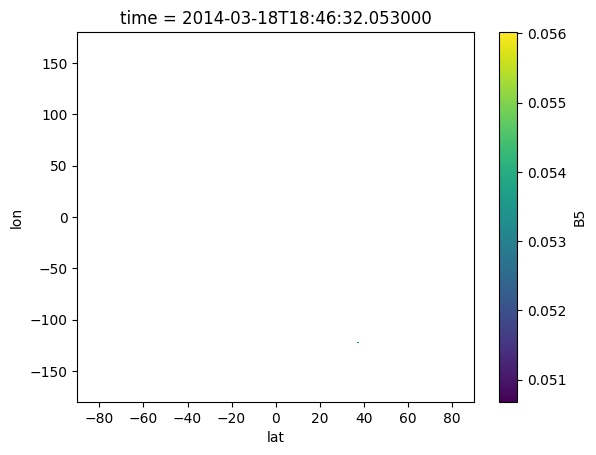

In [ ]:
ds.B5[:,:].plot()

Open multiple ImageCollections into one xarray.Dataset, all with the same projection. This one may take a few minutes to load.

In [ ]:
ds = geemap.ee_to_xarray(
    dataset=["ECMWF/ERA5_LAND/HOURLY", "NASA/GDDP-CMIP6"],
    n_images=100,
    crs="EPSG:4326",
    scale=0.25,
)
ds

<xarray.Dataset>
Dimensions:                                                       (time: 196,
                                                                   lon: 1440,
                                                                   lat: 720)
Coordinates:
  * time                                                          (time) datetime64[ns] ...
  * lon                                                           (lon) float64 ...
  * lat                                                           (lat) float64 ...
Data variables: (12/78)
    dewpoint_temperature_2m                                       (time, lon, lat) float32 dask.array<chunksize=(49, 512, 256), meta=np.ndarray>
    temperature_2m                                                (time, lon, lat) float32 dask.array<chunksize=(49, 512, 256), meta=np.ndarray>
    skin_temperature                                              (time, lon, lat) float32 dask.array<chunksize=(49, 512, 256), meta=np.ndarray>
    soil_temperature_level_1                                      (time, lon, lat) float32 dask.array<chunksize=(49, 512, 256), meta=np.ndarray>
    soil_temperature_level_2                                      (time, lon, lat) float32 dask.array<chunksize=(49, 512, 256), meta=np.ndarray>
    soil_temperature_level_3                                      (time, lon, lat) float32 dask.array<chunksize=(49, 512, 256), meta=np.ndarray>
    ...                                                            ...
    rlds                                                          (time, lon, lat) float32 dask.array<chunksize=(144, 512, 512), meta=np.ndarray>
    rsds                                                          (time, lon, lat) float32 dask.array<chunksize=(144, 512, 512), meta=np.ndarray>
    sfcWind                                                       (time, lon, lat) float32 dask.array<chunksize=(144, 512, 512), meta=np.ndarray>
    tas                                                           (time, lon, lat) float32 dask.array<chunksize=(144, 512, 512), meta=np.ndarray>
    tasmax                                                        (time, lon, lat) float32 dask.array<chunksize=(144, 512, 512), meta=np.ndarray>
    tasmin                                                        (time, lon, lat) float32 dask.array<chunksize=(144, 512, 512), meta=np.ndarray>
Attributes: (12/33)
    date_range:               [347155200000, 1640649600000]
    description:              <p>ERA5-Land is a reanalysis dataset providing ...
    keywords:                 ['cds', 'climate', 'copernicus', 'ecmwf', 'era5...
    period:                   0
    product_tags:             ['temperature', 'lakes', 'snow', 'soil_water', ...
    provider:                 Climate Data Store
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326